Austin Feydt (apf31)

April 13 2018

EECS 531: Assignment 4

# Correlation: Mathematical Background


One intuitive way to describe motion between two linked images is to calculate the shift from the first image to the second image. We would like a way to quantify the local change of each pixel between the images.  One way in particular is to apply our prior knowledge of image filters. For instance, we can calculate the correlation between two image patches to get an estimate of the motion displacement:

$$E_{CC}(u) = \sum_iI_0(x_i)I_1(x_i+u)$$

In this case, $u$ represents the search region.  We will keep this small, as we are assuming that objects aren't moving that quickly between pictures. Making this search region too large will make this less of a local estimate and more of a global one, which we will explore later.

We take the maximum value from the correlation as the maximum response (where the most correlation happens in the patch), and keep the coordinates of this maximum response to plot later.

A more robust estimate can be obtained if we instead consider normalized cross-correlation:

$$E_{NCC}(u) = \frac{\sum_i[I_0(x_i) - \overline{I_0}][I_1(x_i + u)-\overline{I_1}]}{\sqrt{\sum_i[I_0(x_i) - \overline{I_0}]^2[I_1(x_i + u)-\overline{I_1}]^2}}$$

This computes the correlation between the two patches, but also subtracts out the mean of each image, and also normalizes by all of the responses.

# Implementation

### Preprocessing

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import correlate2d

In [2]:
# pads the images by 0 to prevent out-of-range exceptions 
def pad_image(image, kernel_width, kernel_height):
    delta_width = kernel_width // 2
    delta_height = kernel_height // 2
    
    padding = max(delta_width, delta_height)
    padded_image = np.zeros((image.shape[0] + 2*padding, image.shape[1] + 2*padding))   
    
    # overlay image into submatrix of the larger padded_image matrix
    padded_image[padding:-padding, padding:-padding] = image
    return padded_image

# pads images by expected search region dim and returns them in a dictionary
def load_imgs(u0,v0):
    seq1 = {'I1': pad_image(io.imread('data/image/seq1/frame1.png', as_grey=True), u0, v0), 
            'I2': pad_image(io.imread('data/image/seq1/frame3.png', as_grey=True), u0,v0),
            'U' : np.loadtxt('data/flow/seq1/flow3.u', dtype='double', delimiter=','),
            'V' : np.loadtxt('data/flow/seq1/flow3.v', dtype='double', delimiter=',')}

    rubic = {'I1':pad_image(io.imread('data/rubic/rubic.0.png', as_grey=True), u0, v0), 
             'I2':pad_image(io.imread('data/rubic/rubic.5.png', as_grey=True), u0, v0)}

    sphere= {'I1': pad_image(io.imread('data/sphere/sphere.1.png', as_grey=True), u0,v0),
             'I2': pad_image(io.imread('data/sphere/sphere.3.png', as_grey=True), u0, v0)}
    
    earth= {'I1': pad_image(io.imread('data/earth/frame2.png', as_grey=True), u0,v0),
             'I2': pad_image(io.imread('data/earth/frame1.png', as_grey=True), u0, v0)}
    

    return {'seq1': seq1, 'rubic': rubic, 'sphere': sphere, 'earth': earth}
   
# overlays flow arrows onto image
def plotflow(I, X, Y, U, V, scale=1, threshold=-1):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    if threshold > 0:
        mask = np.abs(U + 1j*V) > threshold
        X = X[mask]
        Y = Y[mask]
        U = U[mask]
        V = V[mask]
        
    ax.imshow(I, cmap='gray')
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()


### Estimating moving vector with (normalized) cross-correlation

In [3]:
# calculates either cross-correlation or normalizes it
def estimate_mv_xy(I1, I2, x, y, n, u0, v0, mode):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    n2 = int(np.floor(n/2))
    # extract patch in I1 at x, y
    i11 = y - n2
    i12 = y + n2 + 1
    j11 = x - n2
    j12 = x + n2 + 1
    patch = I1[i11:i12, j11:j12]

    # extract the search region in I2
    i21 = y - n2 - v0
    i22 = y + n2 + 1 + v0
    j21 = x - n2 - u0
    j22 = x + n2 + 1 + u0
    region = I2[i21:i22, j21:j22]

    # correlation
    if mode == 'cc':
        response = correlate2d(region, patch, 'valid')
    
    # normalized correlation
    else:
        # subtract out the mean
        region = region - np.mean(I2) * np.ones(region.shape)
        patch = patch - np.mean(I1) * np.ones(patch.shape)
        response = correlate2d(region, patch, 'valid')
        
        # square the matrices
        norm_region = np.power(region, 2)
        norm_patch = np.power(patch, 2)
        norm_response = correlate2d(norm_region, norm_patch, 'valid')
        
        # calculate normalizing constant and normalize
        norm_response = np.std(norm_response)
        response = response / norm_response
     
    # find the indices of max response
    i, j = np.unravel_index(response.argmax(), response.shape)
    
    # calculate mv
    u = j21 - j11 + j
    v = i21 - i11 + i
    return (u, v)

In [4]:
# estimates motion vectors using correlation approach
def estimate_mv(I1, I2, gridX, gridY, n, u0, v0, mode):
    H, W = gridX.shape # the height and width of output 
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    # iterate over the grid
    for i in range(0, H):
        for j in range(0, W):
            u, v =  estimate_mv_xy(I1, I2,gridX[i, j], gridY[i, j], n, u0, v0, mode)
            U[i, j] = u
            V[i, j] = v
            
    return (U, V)

### Results

Cross-Correlation:


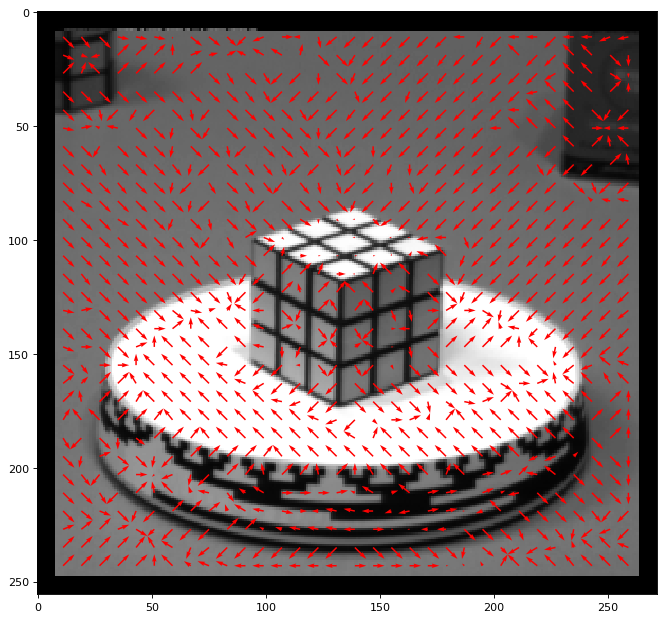

Normalized Cross-correlation:


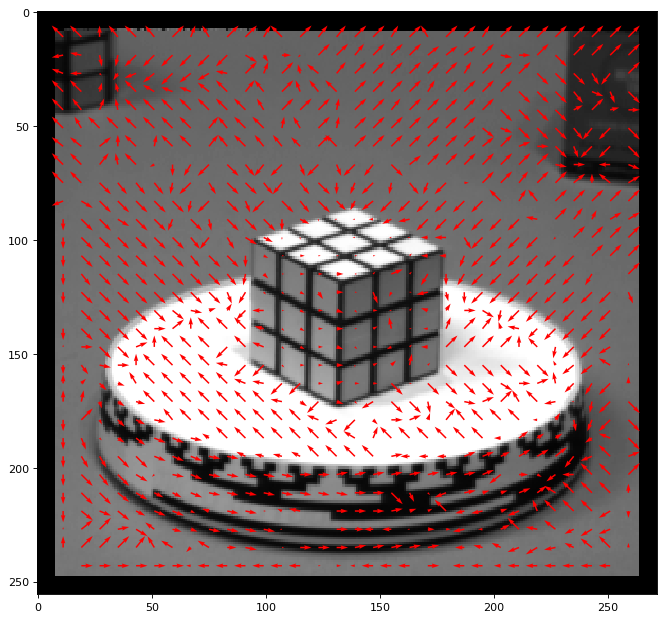

In [5]:
def test_estimate_mv(img):
    gridsz = 8
    wsz  = 11
    u0 = 5
    v0 = 5
    u_tot = np.floor(wsz/2) + u0//2
    v_tot = np.floor(wsz/2) + v0//2
    imgs = load_imgs(wsz+u0, wsz + v0)
    seq = imgs[img]
    H, W = seq['I1'].shape
    
    x = np.arange(u_tot, W-gridsz - u_tot, gridsz) + np.floor(gridsz/2); #np.floor(gridsz/2);
    y = np.arange(v_tot, H-gridsz - v_tot, gridsz) + np.floor(gridsz/2); # + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U, V = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0, 'cc')
    print('Cross-Correlation:')
    plotflow(seq["I1"], gridX, gridY, U, V, 1, 0.3)
    print('Normalized Cross-correlation:')
    U, V = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0, 'ncc')
    plotflow(seq["I1"], gridX, gridY, U, V, 1, 0.3)


    #plt.hist(U.flatten())
    #plt.hist(V.flatten())

test_estimate_mv('rubic')

For the rubic's cube, he results obtained by just using cross-correlation are almost completely useless. The cube is the focal point of the data, and the flow vectors on it are pointing in many different conflicting areas, not capturing the intended counter-clockwise rotation.  However, we can see that for normalized-cross validation, there's some actual substance to the vectors.  The arrows over the cube show mostly a CCW rotation, with the arrows pointing to the right. Also, the bottom of the circular platform shows mostly right-arrows, which is what is desired.

# Gradient Constraint: Mathematical Background

If we assume that the image intensity of a moving point doesn't change over time and the intensities are smooth enough that we can compute local derivates, we have:
$$ { \frac{\partial I}{\partial x}} u + { \frac{\partial I}{\partial y}} v + { \frac{\partial I}{\partial t}}= 0,$$
where $(u, v)$ is the velocity of the point at $(x, y)$. This equation is called the motion constraint equation. It expresses the relationship between the spatial and temporal derivatives of the image in terms of the image velocity. 

From calculus, we can approximate a derivative by using the 2-sided difference equation:
$$ f'(x) = \frac{f(x+h) - f(x-h)}{2h}$$ 

And if we let h=1, we get the following equations:
\begin{aligned}
\frac{\partial I}{\partial x} = I_x &= \frac{I(x+1, y) - I(x-1, y)}{2} \\
\frac{\partial I}{\partial y} = I_y &= \frac{I(x, y+1) - I(x, y-1)}{2} \\ 
\frac{\partial I}{\partial t} = I_t &= \frac{I(x, t+1) - I(x, t-1)}{2}
\end{aligned}

When just given two frames, we can approximate the temporal gradient by
$$I_t = I(x, t+1) - I(x, t).$$

# Implementation

In [6]:
# Calculates the gradient
def gradient_xyt(I1, I2, x, y):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    
    Ix = (I1[y, x+1] - I1[y, x-1])/2
    Iy = (I1[y+1, x] - I1[y-1, x])/2
    It = I2[y,x] - I1[y,x]
    return (Ix, Iy, It)

def getAb(I1, I2, x, y, n):
    A = np.zeros((n*n, 2))
    b = np.zeros(n*n)
    
    # compute the relative positions of pixels in a window
    offset = np.arange(0, n) - np.floor(n/2); 
    dx, dy = np.meshgrid(offset, offset);
    dx = dx.reshape(n*n, 1);
    dy = dy.reshape(n*n, 1);
    
    # compute the elements of A and b
    for i in range(0, n*n):
        Ix, Iy, It = gradient_xyt(I1, I2, x+dx[i], y+dy[i])
        A[i, 0] = Ix 
        A[i, 1] = Iy
        b[i] = -It
        
    return (A, b)


def estimate_flow_at_xy(I1, I2, x, y, n):
    A, b = getAb(I1, I2, x, y, n)
 
    result = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
    # result = np.linalg.lstsq(A, b)
    v = result[0]
    return v

def estimate_flow(I1, I2, gridX, gridY, n):
    H, W = gridX.shape # the height and width of output 
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    # iterate over the grid
    for i in range(0, H):
        for j in range(0, W):
            v =  estimate_flow_at_xy(I1, I2,gridX[i, j], gridY[i, j], n)
            U[i, j] = v[0]
            V[i, j] = v[1]
    return (U, V)

# Results

Normalized Cross-Correlation


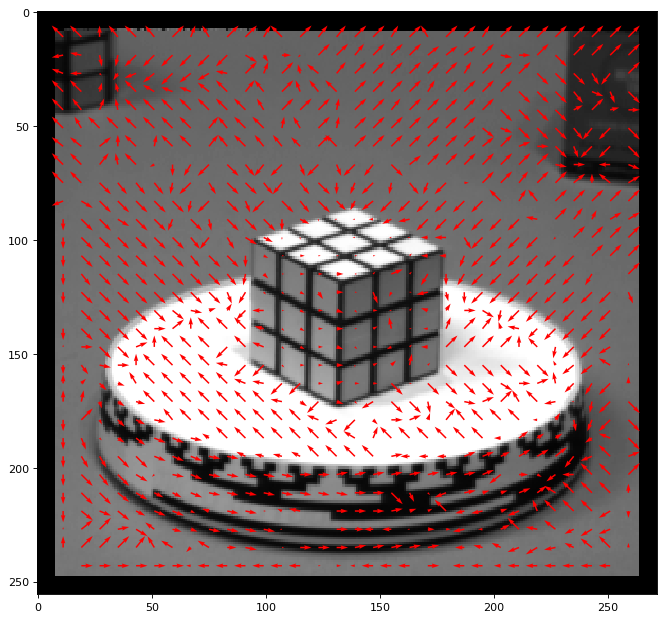

Gradient Equations:


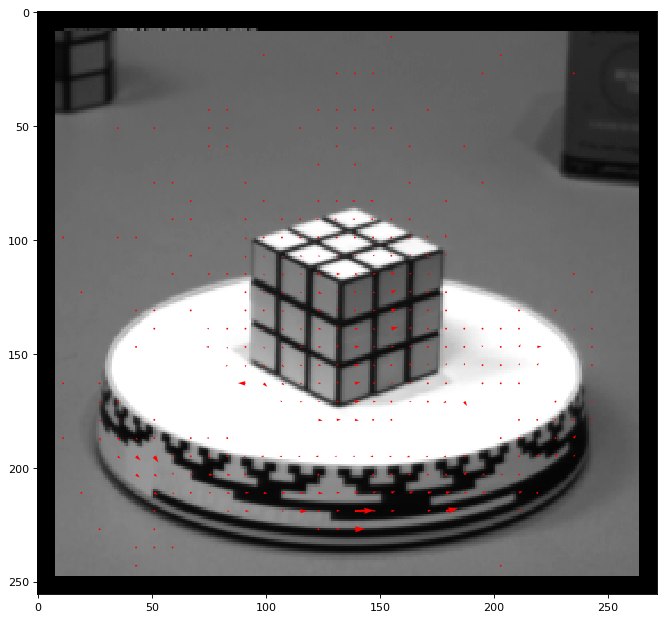

Normalized Cross-Correlation


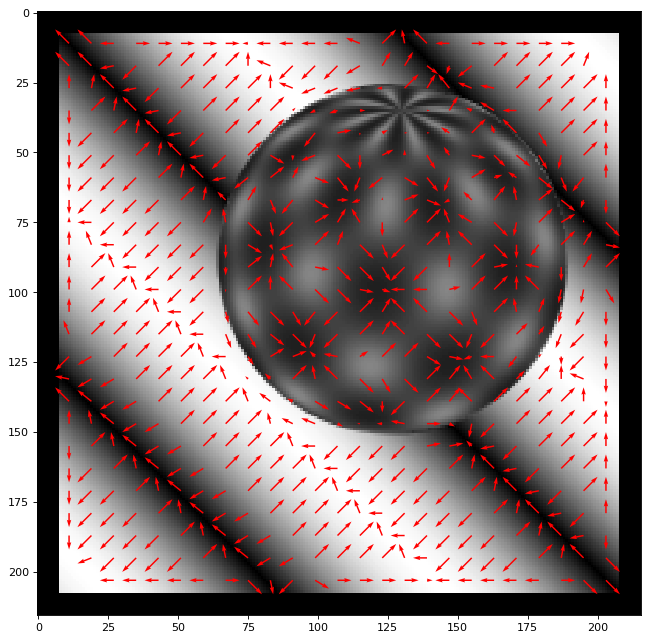

Gradient Equations:


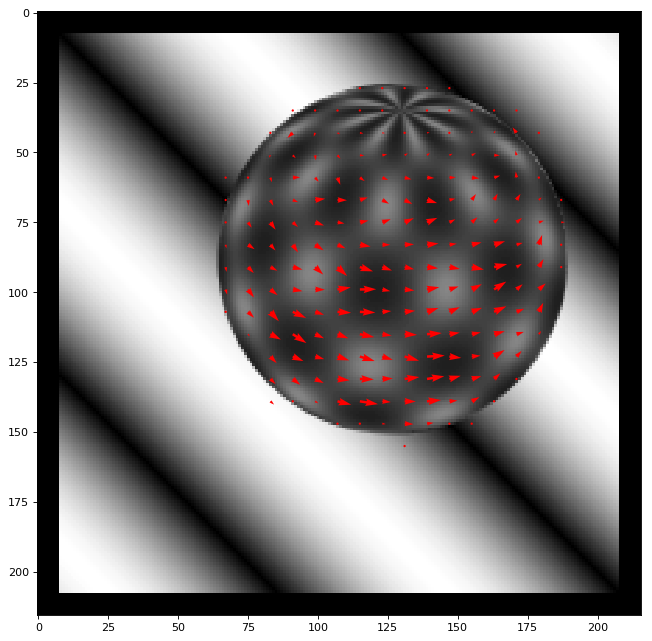

In [7]:
 def comp(img):
    gridsz = 8
    wsz  = 11
    u0 = 5
    v0 = 5
    u_tot = np.floor(wsz/2) + u0//2
    v_tot = np.floor(wsz/2) + v0//2
    imgs = load_imgs(wsz+u0, wsz + v0)
    seq = imgs[img]
    H, W = seq['I1'].shape
    
    x = np.arange(u_tot, W-gridsz - u_tot, gridsz) + np.floor(gridsz/2);
    y = np.arange(v_tot, H-gridsz - v_tot, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U1, V1 = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    U2, V2 = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0, 'ncc') 
    print('Normalized Cross-Correlation')
    plotflow(seq["I1"], gridX, gridY, U2, V2, 1, 0.3)
    print('Gradient Equations:')
    plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    
comp('rubic')
comp('sphere')

For the rubic's cube, we can see that both methods lead to similar motion-vectors when we look at the cube and the platform.  However, the gradient-method definitely does a better job at tuning out the noise in the background, whereas the normalized-correlation picks up motion that does not exist in the background.

For the sphere, the vectors generate by normalized-correlation are very spuratic.  Along the edges of the sphere, we see that it recognizes some of the rotation, but towards the center, it seems to think that different parts of the ball are going in different directions. This is because of the lighting on the ball.  The gradient method ignores all movement in the background, and seems to pick up some of the CCW rotation of the ball.

All in all, we can see that the gradient-method works much better with the addition of noise, and is able to much better estimate motion for rotating objects.  Also, normalzing the cross-correlation leads to much better results than not normalizing it.